<a href="https://colab.research.google.com/github/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/main_sudoku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sudoku Reader

In this project a software is developed which recognizes a Sudoku puzzle and solves it automatically.

![Sudoku Puzzle](https://github.com/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/Aufgabe.jpg?raw=1)

## Group members:
* Justine Bruns (Business Informatics)

* Dennis Kempf (Computing Science)

* Mykhailo Ievreinov (Business Informatics)



# Milestones

## Define requirements

In which use cases is a Sudoku solver used?

## Detect Sudoku grid

1. Acquire input image to be analyzed
    1. Read static image from storage
    2. Use real time video stream (optional)

2. Preprocess input image for further analysis

3. Detect shape of Sudoku grid within preprocessed image

![Detect grid](https://github.com/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/documentation/detect_grid.png?raw=1)

## Recognize digits

1. Apply perspective transformation to Sudoku grid

![](https://github.com/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/documentation/transform_grid.png?raw=1)

2. Extract cells from grid image

![](https://github.com/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/documentation/extract_cells.png?raw=1)

3. Recognize digits (1 to 9) within cells
    1. Recognize computer generated digits by classical means (e. g. template matching)
    2. Recognize handwritten digits using artificial neural networks (trained on MNIST dataset)
    3. Mark empty cells

![](https://github.com/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/documentation/recognize_digits.png?raw=1)

## Solve puzzle

1. Store recognized digits within matrix data structure 

2. Feed data structure into existing Sudoku solver

![](https://github.com/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/documentation/solve_puzzle.png?raw=1)

3. Output solution to user
    1. Print solved matrix in console
    2. Draw solution onto input image (AR, optional)

![](https://github.com/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/documentation/output_ar.png?raw=1)

# Scenarios

* Sudoku puzzles without entries
* Numbers are difficult to recognize
  * Bad image quality
  * Unclear handwriting
* Image in different rotations
* Multiple Sudokus in one image
  * Maybe a puzzle is not completely visible
* Sudoku in different colors
* Sudoku can have more than one solution
* Sudoku only with handwritten numbers
* Different perspectives on the puzzle
* First numbers were entered into the puzzle, but are incorrect


# Implementation
The following chapters describe the implementation of our Sudoku solver based on the requirements and milestones defined above.

## Acquire Input Images


Our goal is to solve a Sudoku puzzle which is contained within an image (or stream of images).
Thus, first of all, we have to acquire some images to be analyzed.
For the first part of this implementation, we will read a set of static images from our GitHub repository.

The corresponding URLs are defined by the following array.

In [0]:
base_input_image_url = "https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/examples"
input_image_urls = [base_input_image_url + "/356/1.jpg",
                    base_input_image_url + "/356/2.jpg",
                    base_input_image_url + "/356/3.jpg",
                    base_input_image_url + "/356/hwd.jpeg",
                    base_input_image_url + "/537/IMG_000.jpeg",
                    base_input_image_url + "/537/IMG_001.jpeg",
                    base_input_image_url + "/537/IMG_002.jpeg"]

We use the **scikit-image** library to download the images specified by the above array.
This library provides a method `io.imread` which reads images not only from local storage, but also from remote origins specified as URLs.
In contrast to OpenCV which encodes color images in BGR format, this method uses the more common RGB encoding.

In [0]:
from skimage import io
from os.path import basename

def download_image(url):
  print("Downloading", url, "...")
  filename = basename(url)
  image = io.imread(url) # encoded in RGB
  return { 
      "url": url,
      "filename": filename,
      "data": image
  }

The downloaded images are stored, together with some meta data, in a `DataFrame` provided by the **Pandas** library.

In [3]:
import pandas as pd

def download_all_images(urls):
  print("Downloading", len(urls), "images...")
  images = [download_image(x) for x in urls]
  return pd.DataFrame(images)

input_images = download_all_images(input_image_urls)
input_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 3 columns):
url         7 non-null object
filename    7 non-null object
data        7 non-null object
dtypes: object(3)
memory usage: 296.0+ bytes


For demonstration purposes the images are then displayed using the **matplotlib** library.

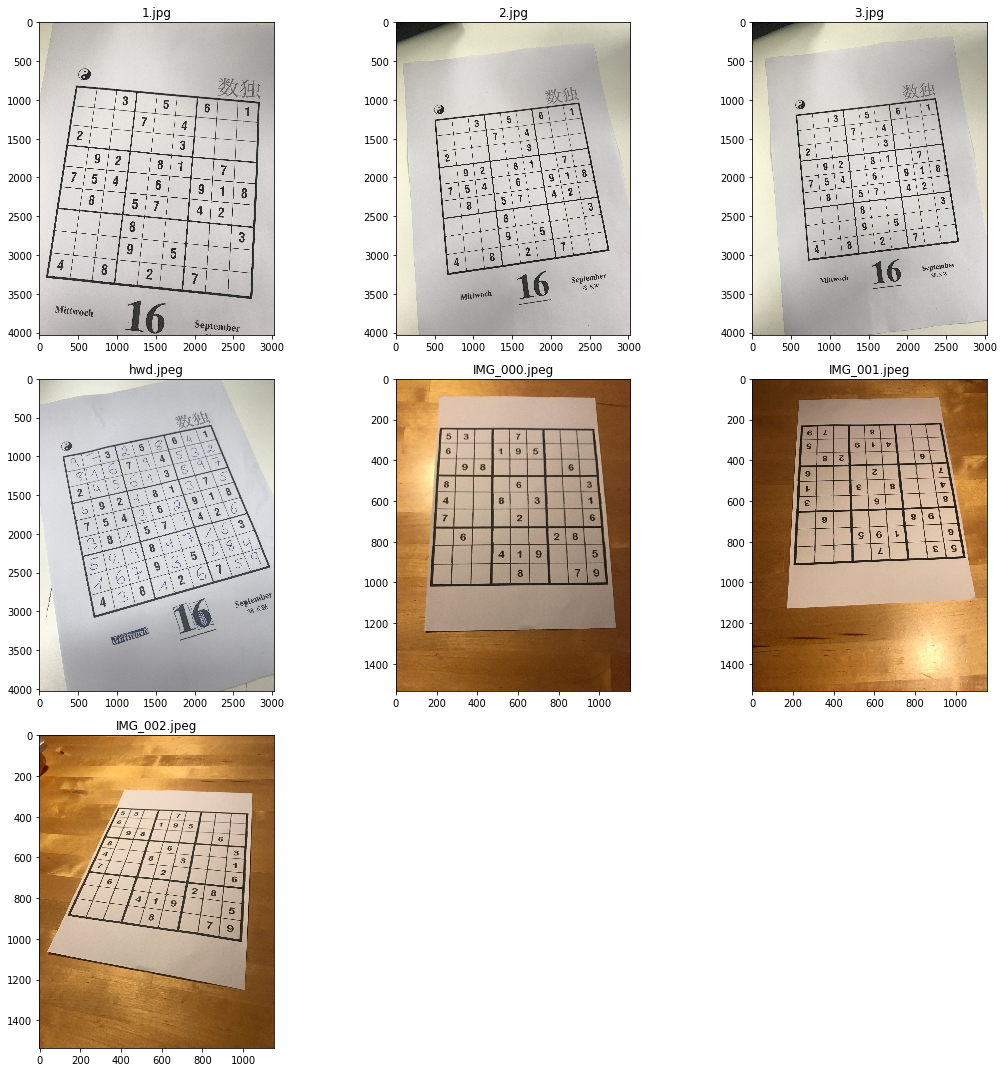

In [4]:
import matplotlib.pyplot as plt
import math

def show_images(images, titles=[], cmap=None, rows=None, columns=None, scaling=(5, 5)):
  if rows is None and columns is None:
    rows = math.ceil(math.sqrt(len(images)))
  if rows is None:
    rows = math.ceil(len(images) / columns)
  if columns is None:
    columns = math.ceil(len(images) / rows)

  plt.figure(figsize=(scaling[1] * columns, scaling[0] * rows))
  for i, image in enumerate(images):
    plt.subplot(rows, columns, i + 1)
    if i < len(titles):
      plt.title(titles[i])
    plt.imshow(image, cmap=cmap)
  plt.tight_layout()
  plt.show()

show_images(input_images["data"], titles=input_images["filename"])

## Preprocess Input Image
Within each of our input images we need to detect the Sudoku grid.
This detection will be done by analyzing the image contours using the **OpenCV2** library.
The `findContours` method requires the image to be binary, i. e. each pixel is completely black or completely white with no inbetween these two colors.
Based on these black and white regions contours/edges will be determined.
But our input images currently contain three color channels, namely **R**ed, **G**reen and **B**lue.
These have to be reduced in an favourable way that keeps the grid contours clearly recognizable.

We start by converting our RGB images to grayscale images using the method `cvtColor` provided by OpenCV.

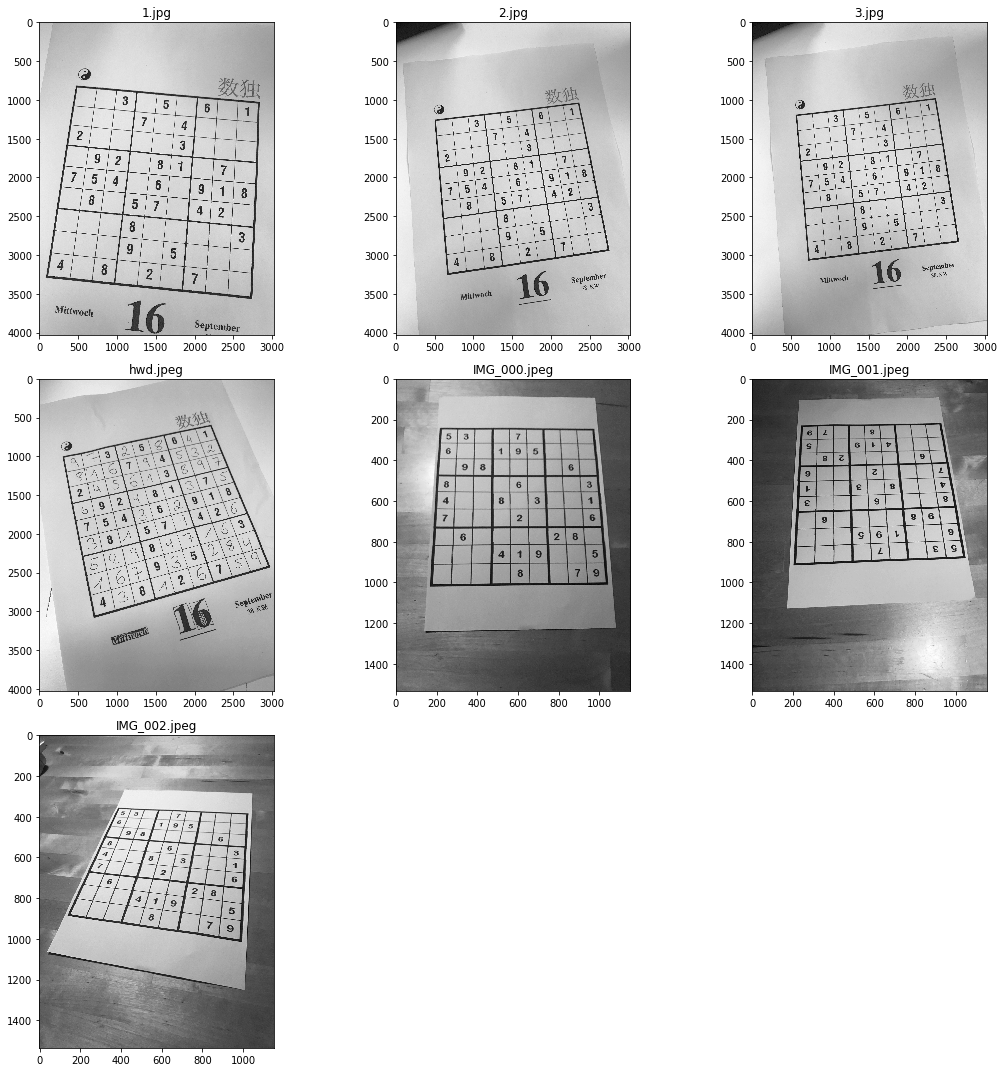

In [5]:
import cv2 as cv

def convert_to_grayscale(image):
  return cv.cvtColor(image, cv.COLOR_RGB2GRAY)

grayscale_input_images = [convert_to_grayscale(x) for x in input_images["data"]]
show_images(grayscale_input_images, titles=input_images["filename"], cmap="gray")

Grayscale images only have one "color" channel, but this one is still not binary.
For this reason we use thresholding, which maps values below some threshold x to "completely black" and values above x to "completely white".
More precisely we use a technique called "adaptive thresholding" which requires us to define a "block size".
The method `adaptiveThreshold` from OpenCV requires the block size to be specified by a number of pixels.
Because we accept different kinds of images with varying resolutions, we define it relative to the image resolution and then convert to an absolute number of pixels as required.


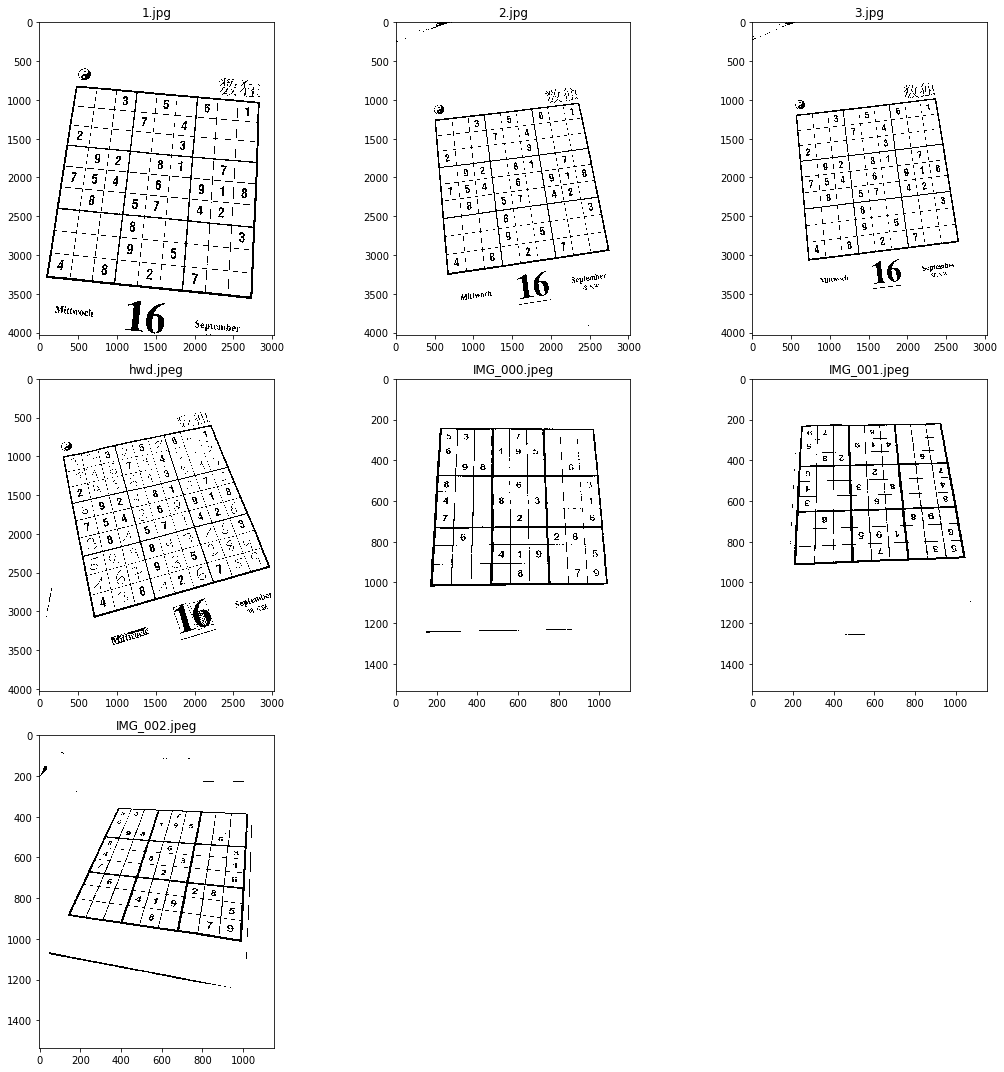

In [6]:
#@title Threshold Configuration { run: "auto" }
default_threshold_block_size = 0.5 #@param { type: "slider", min: 0, max: 1, step: 0.1 }
default_threshold_bias = 64 #@param { type:"slider", min: -255, max: 255, step: 1 }

def threshold_image(image, 
                    method=cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                    block_size=default_threshold_block_size, 
                    bias=default_threshold_bias):
  # convert relative block size to absolute block size
  width, height = image.shape
  block_size = int(block_size * min(width, height))
  # if block_size is even, we must make it uneven (see def. of adaptiveThreshold)
  if block_size % 2 == 0:
    block_size += 1
  return cv.adaptiveThreshold(image, 255, method, cv.THRESH_BINARY, block_size, bias)

thresh_input_images = [threshold_image(x) for x in grayscale_input_images]
show_images(thresh_input_images, titles=input_images["filename"], cmap="gray")


## Detect Shape of Sudoku Grid
Finally we can try to detect the shape of a Sudoku grid within each image.
As previously mentioned we do this using the method `findContours` provided by OpenCV.

In [0]:
def find_contours(image):
  # image must be inverted, because findContours treats white as foreground and black as background
  # if we don't invert the image, the image border will be detected as a contour
  image = cv.bitwise_not(image)
  contours, _ = cv.findContours(image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  return contours

contours = [find_contours(x) for x in thresh_input_images]

The set of found contours can be visualized using the method `drawContours` provided by OpenCV.

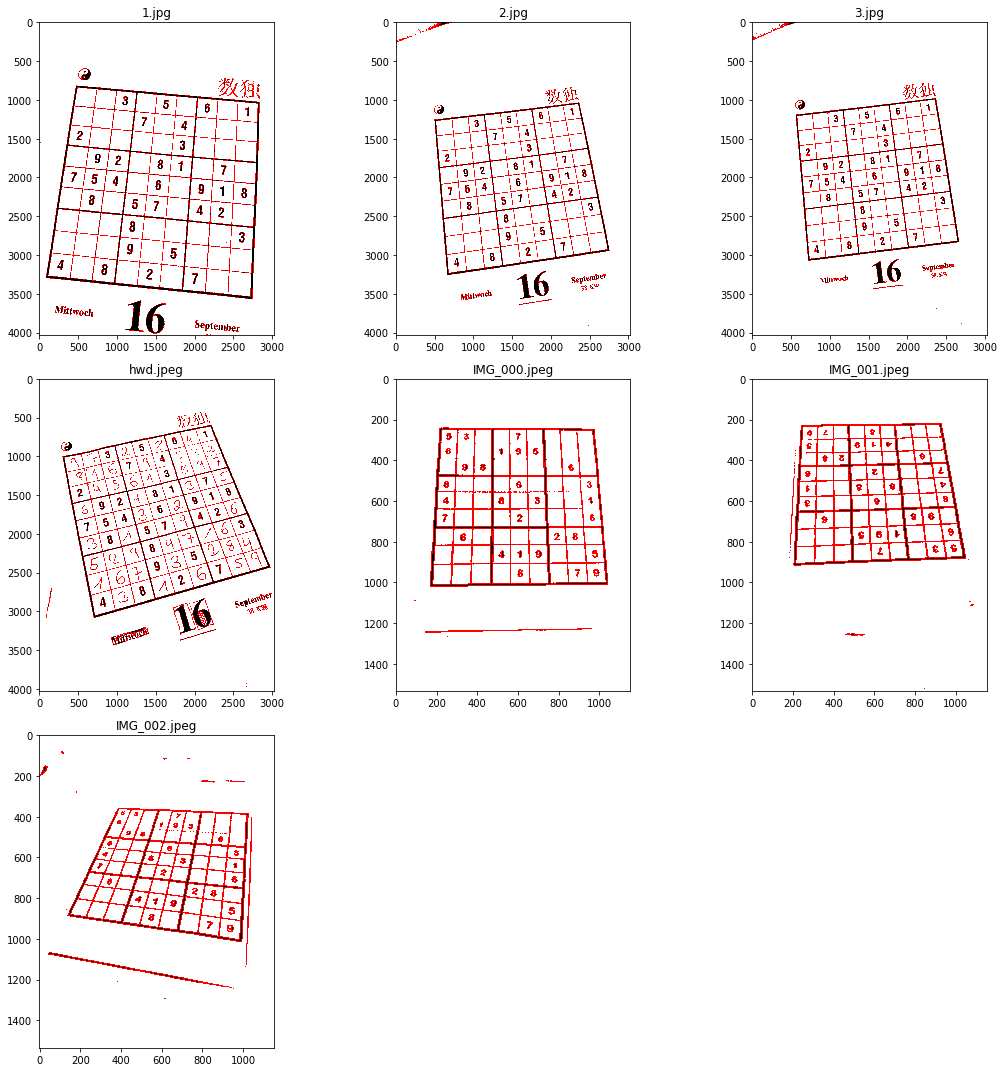

In [8]:
def draw_contours(image, contours):
  # convert image from grayscale to BGR
  image = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
  # draw contours using OpenCV
  cv.drawContours(image, contours, -1, color=(0, 0, 255), thickness=4)
  return cv.cvtColor(image, cv.COLOR_BGR2RGB)

images_with_contours = [draw_contours(x, y) for x, y in zip(thresh_input_images, contours)]
show_images(images_with_contours, titles=input_images["filename"])

From all of the detected contours we now have to determine which contours are actually corresponding to our Sudoku grid.

**Assumption**: The Sudoku grid always has a square border.

**Idea:** A square has exactly four sides. Thus we can filter out all contours having less than or more than four sides.

The contours generated by `findContours` can be very *wiggly* causing us to overestimate the actual number of sides.
To counter that, we approximate all contours using the method `approxPolyDP` that is also provided by OpenCV.

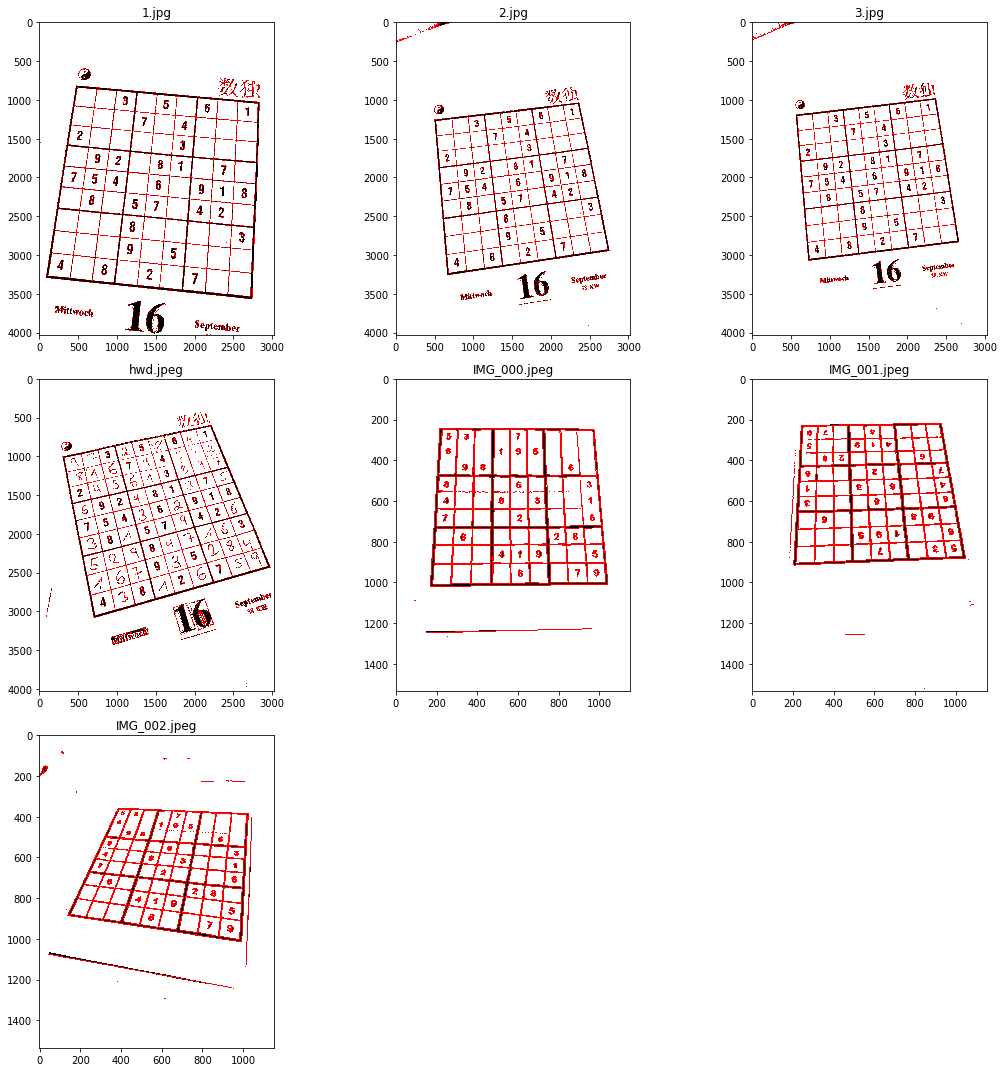

In [9]:
def approximate_contour(contour, precision=0.1):
  # convert relative precision to absolute precision (epsilon)
  _, _, width, height = cv.boundingRect(contour)
  epsilon = max(width, height) * precision
  return cv.approxPolyDP(contour, epsilon, closed=True)

approximated_contours = [[approximate_contour(y) for y in x] for x in contours]
images_with_contours = [draw_contours(x, y) for x, y in zip(thresh_input_images, approximated_contours)]
show_images(images_with_contours, titles=input_images["filename"])

Now we can actually filter out all contours that are not foursided.

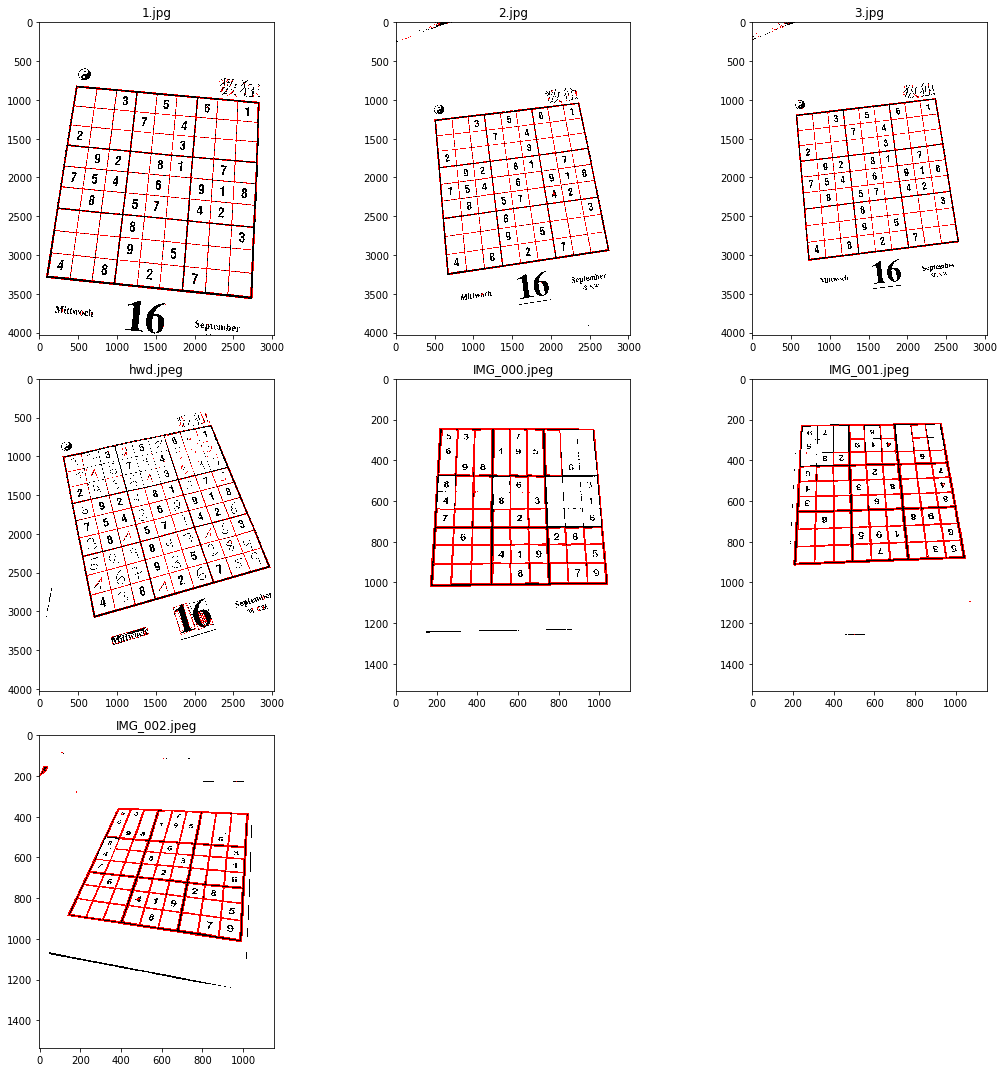

In [10]:
def get_foursided_contours(contours):
  candidates = []
  for contour in contours:
    if len(contour) != 4:
      continue
    candidates.append(contour)
  return candidates

foursided_contours = [get_foursided_contours(x) for x in approximated_contours]
images_with_contours = [draw_contours(x, y) for x, y in zip(thresh_input_images, foursided_contours)]
show_images(images_with_contours, titles=input_images["filename"])

But which of these foursided contours is our Sudoku square?

**Assumption:** The Sudoku grid is always the largest foursided object within all images.

**Idea:** Sort contours by circumference and choose the largest one.

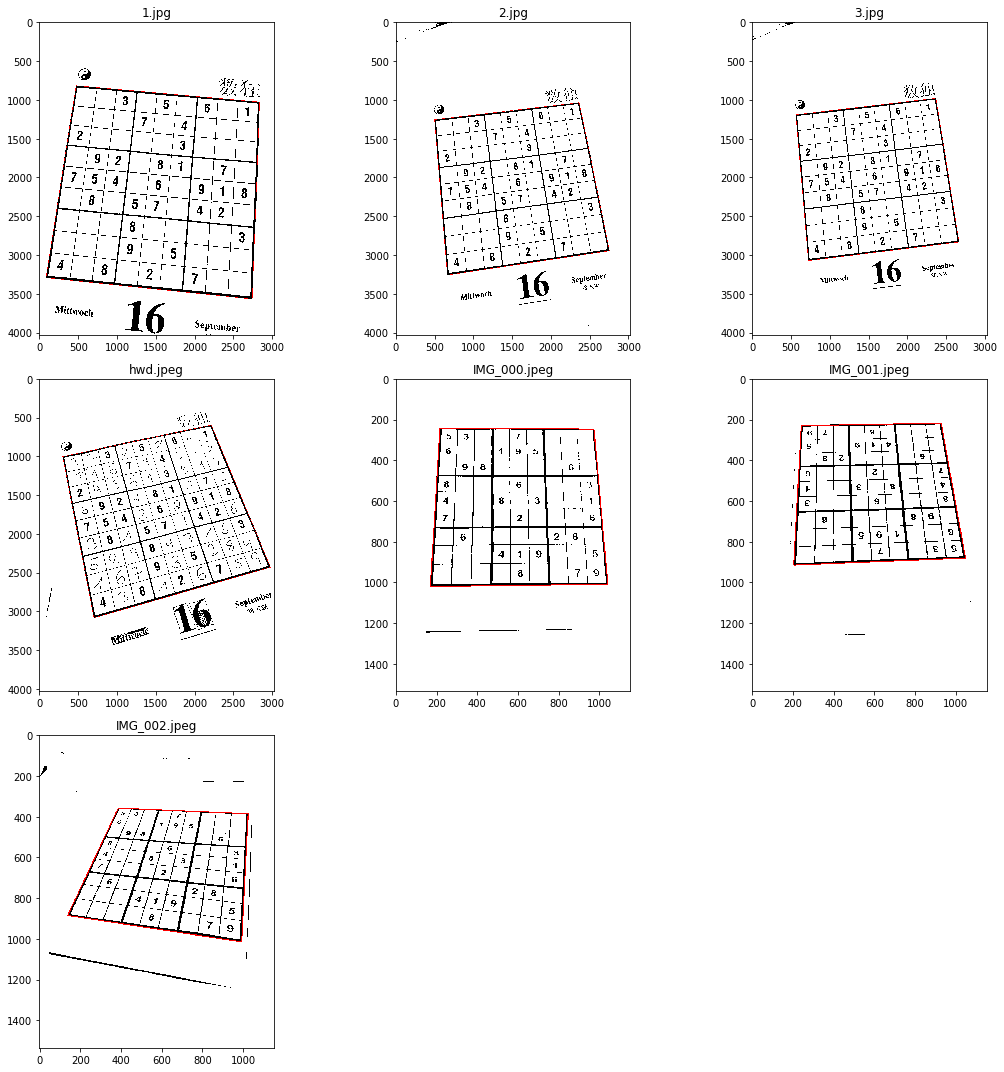

In [11]:
import numpy as np

def get_largest_contour(contours):
  lengths = [cv.arcLength(x, closed=True) for x in contours]
  longest = np.argmax(lengths)
  return contours[longest]

largest_contours = [get_largest_contour(x) for x in foursided_contours]
images_with_contours = [draw_contours(x, [y]) for x, y in zip(thresh_input_images, largest_contours)]
show_images(images_with_contours, titles=input_images["filename"])

## Apply perspective transformation
Because we now know all four corner points of the Sudoku grid, we can apply a transformation to those, removing distortions caused by the camera's perspective.
This transformation is done by first calculating a transformation matrix using OpenCV's `getPerspectiveTransform` and then applying this transformation to our source image using `warpPerspective`.
The method `getPerspectiveTransform` requires us to define a list of source points that are mapped to a list of target points.
For this mapping the order of the points is very important.
If the orders don't match, the resulting image could be rotated by 90°, 180° or 270°.
For this reason, we define a method `sort_corners` that sorts the rectangle's corners in a deterministic way:
- The top-left corner A has the smallest sum of x + y values
- The bottom-left corner B has the largest diff. of y - x values
- The bottom-right corner C has the largest sum of x + y values
- The top-right corner D has the smallest diff. of y - x values

In [0]:
# https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
def sort_contour(contour):
  corners = np.reshape(contour, (4, 2))
  indices = np.zeros((4,), dtype="int")
  sums = np.sum(corners, axis=1)
  # [0]: top left corner (smallest sum x + y)
  indices[0] = np.argmin(sums)
  # [2]: bottom right corner (largest sum x + y)
  indices[2] = np.argmax(sums)
  diffs = np.diff(corners, axis=1)
  # [1]: bottom left corner (largest diff. y - x)
  indices[1] = np.argmax(diffs)
  # [3]: top right corner (smallest diff. y - x)
  indices[3] = np.argmin(diffs)
  return corners[indices]
  
sorted_contours = [sort_contour(x) for x in largest_contours]

For the following transformations we have to define the size of our target square.
This could be done in a static way, e. g. scale every image of a Sudoku grid to a 1024x1024 rectangle, or we choose our target dimensions based on the analyzed image.
We decided to use the detected contours circumfrence as a reference for our square side length, which is calculated by the `get_grid_size` method.  

In [0]:
def get_side_length(contour):
  return int(cv.arcLength(contour, closed = True) / 4)

side_lengths = [get_side_length(x) for x in sorted_contours]

As we now know the side lengths of our target squares, we can construct the list of target points the source points are mapped to.
These target points correspond to the four corner points of a square, which are constructed by the method `get_target_contour`.

In [0]:
def get_target_contour(side_length):
  a = [0, 0]
  b = [0, side_length]
  c = [side_length, side_length]
  d = [side_length, 0] 
  return np.array([a, b, c, d]) 

target_contours = [get_target_contour(x) for x in side_lengths] 

From the list of sorted source contours/points and the respective target points we can calculate the necessary linear transformation that warps the source images in the desired way using `get_transformation` which internally invokes OpenCV's `getPerspectiveTransform`. 

In [0]:
def get_transformation(source, destination):
  source = source.astype("float32")
  destination = destination.astype("float32")
  return cv.getPerspectiveTransform(source, destination)

transformations = [get_transformation(x, y) for x, y in zip(sorted_contours, target_contours)]

The resulting transformation matrix can in turn be applied to the source image using `apply_transformation` which invokes OpenCV`s `warpPerspective` method.
Our source images now look like they have been shot straight from above.
Depending on how the Sudoku grid was oriented within the source image, the output image may be rotated. 

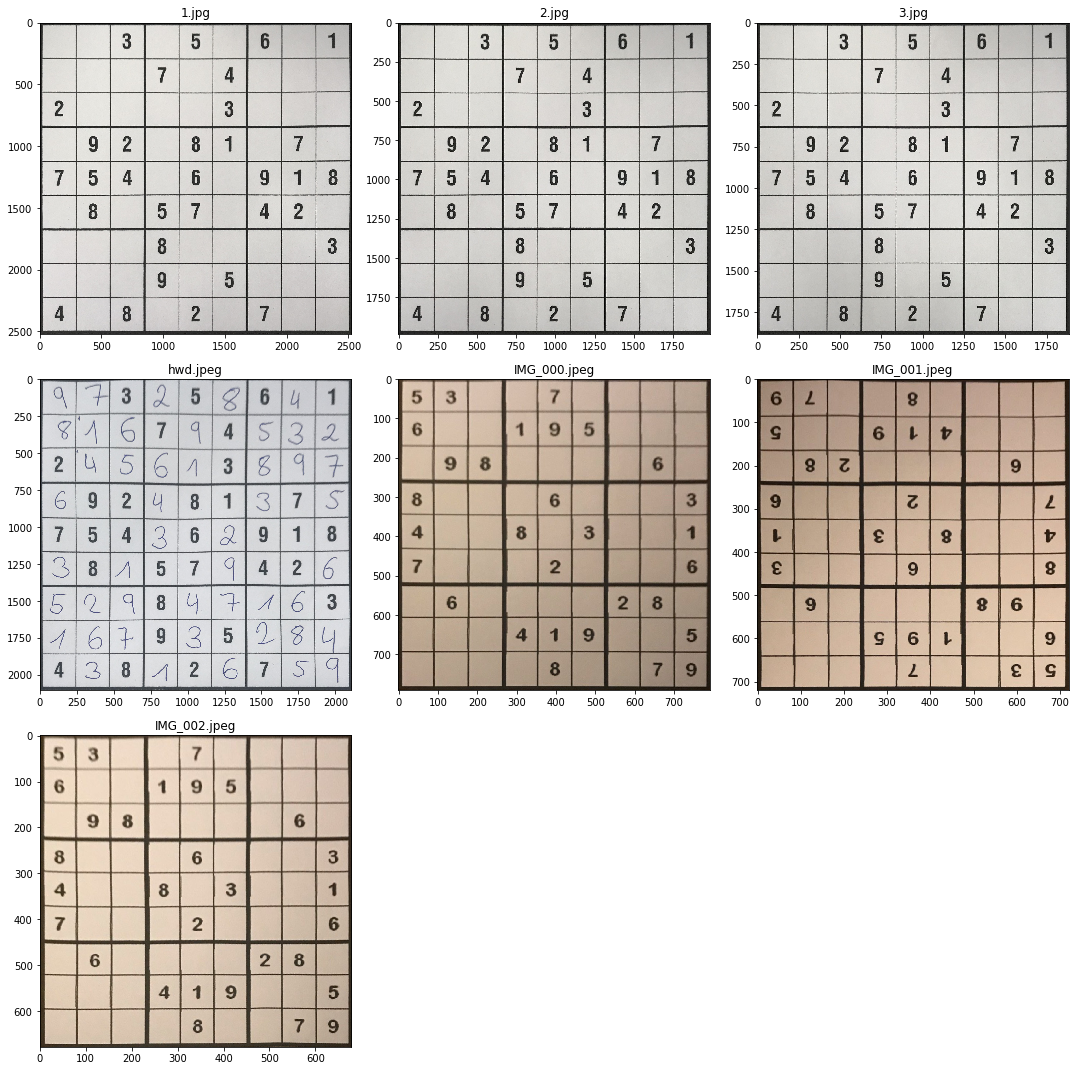

In [16]:
def apply_transformation(image, transformation, side_length):
  return cv.warpPerspective(image, transformation, (side_length, side_length))

transformed_images = [apply_transformation(x, y, z) for x, y, z in zip(input_images["data"], transformations, side_lengths)]
show_images(transformed_images, input_images["filename"])

## Extract cells from grid image

After having corrected the input image's perspective, the extraction of cells themself is rather easy under a few assumptions:

*   Each Sudoku grid consists of exactly 9 rows and 9 columns
*   Each Soduku grid is made up of equally sized squares

Under these assumptions we do not have to detect any sort of lines, but instead we can simply devide the image into a 9-by-9 grid of squares.
Each square should then contain exactly one Sudoku cell.
This division is implemented by the method `extract_cells` which accepts an corrected image and returns a list of 9 rows each containing 9 columns corresponding to the cells of the Sudoku puzzle.

In [0]:
def extract_cells(image):
  split = np.array_split(image, 9)
  for i, x in enumerate(split):
    split[i] = np.array_split(x, 9, axis=1)
  #show_images(split[0])
  return split

cells = [extract_cells(x) for x in transformed_images]

The variable `cells` now contains all extracted cell images. The element `cells[i][j][k]` contains the image of the cell in the `i`-th image located in the `j`-th row and the `k`-th column.
Using the method `show_cells` we can visualize the extracted cell images of a puzzle.

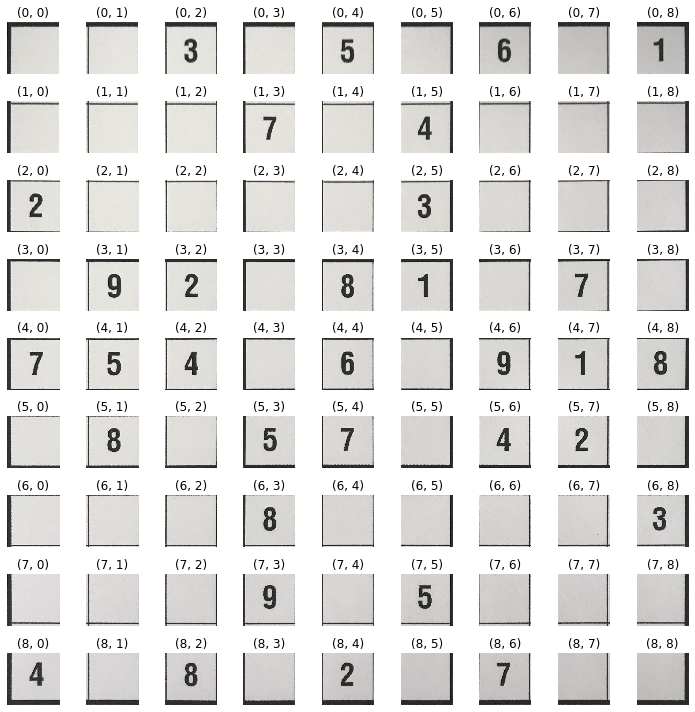

In [18]:
def show_cells(cells, **kwargs):
  plt.figure(figsize=(10, 10))
  rows = len(cells)
  assert rows == 9
  cols = len(cells[0])
  assert cols == 9
  counter = 0
  for row in range(rows):
    for col in range(cols):
      counter += 1
      plt.subplot(rows, cols, counter)
      plt.title(str((row, col)))
      plt.axis("off")
      plt.imshow(cells[row][col], **kwargs)
  plt.tight_layout()
  plt.show()

show_cells(cells[0])

## Recognize digits within cells

Our task is now to recognize the digits shown in each extracted cell.
For this purpose we first define the ground truth values we want to predict in an array called `actual_grids`. This array must be kept in sync with the loaded input images.

In [0]:
actual_grids = []
for i in range(3):
  actual_grids.append([[0, 0, 3, 0, 5, 0, 6, 0, 1],
                       [0, 0, 0, 7, 0, 4, 0, 0, 0],
                       [2, 0, 0, 0, 0, 3, 0, 0, 0],
                       [0, 9, 2, 0, 8, 1, 0, 7, 0],
                       [7, 5, 4, 0, 6, 0, 9, 1, 8],
                       [0, 8, 0, 5, 7, 0, 4, 2, 0],
                       [0, 0, 0, 8, 0, 0, 0, 0, 3],
                       [0, 0, 0, 9, 0, 5, 0, 0, 0],
                       [4, 0, 8, 0, 2, 0, 7, 0, 0]])
actual_grids.append([[9, 7, 3, 2, 5, 8, 6, 4, 1],
                     [8, 1, 6, 7, 9, 4, 5, 3, 2],
                     [2, 4, 5, 6, 1, 3, 8, 9, 7],
                     [6, 9, 2, 4, 8, 1, 3, 7, 5],
                     [7, 5, 4, 3, 6, 2, 9, 1, 8],
                     [3, 8, 1, 5, 7, 9, 4, 2, 6],
                     [5, 2, 9, 8, 4, 7, 1, 6, 3],
                     [1, 6, 7, 9, 3, 5, 2, 8, 4],
                     [4, 3, 8, 1, 2, 6, 7, 5, 9]])
for i in range(3):
  actual_grids.append([[5, 3, 0, 0, 7, 0, 0, 0, 0],
                       [6, 0, 0, 1, 9, 5, 0, 0, 0],
                       [0, 9, 8, 0, 0, 0, 0, 6, 0],
                       [8, 0, 0, 0, 6, 0, 0, 0, 3],
                       [4, 0, 0, 8, 0, 3, 0, 0, 1],
                       [7, 0, 0, 0, 2, 0, 0, 0, 6],
                       [0, 6, 0, 0, 0, 0, 2, 8, 0],
                       [0, 0, 0, 4, 1, 9, 0, 0, 5],
                       [0, 0, 0, 0, 8, 0, 0, 7, 9]])


The element `actual_grids[i][j][k]` contains the digit of the cell in the `i`-th image located in the `j`-th row and `k`-th column.
Empty cells contain the number `0` which never occurs in a Sudoku puzzle.
The grid data structure for a specific image can be visualized using the method `print_grid` which prints the non-zero digits in the console.

In [20]:
def print_grid(grid):
  print("-------------------------------------")
  for row in grid:
    for col in row:
      if col >= 1 and col <= 9:
        print("| {} ".format(col), end="")
      else:
        print("|   ", end="")
    print("|\n-------------------------------------")

print_grid(actual_grids[0])

-------------------------------------
|   |   | 3 |   | 5 |   | 6 |   | 1 |
-------------------------------------
|   |   |   | 7 |   | 4 |   |   |   |
-------------------------------------
| 2 |   |   |   |   | 3 |   |   |   |
-------------------------------------
|   | 9 | 2 |   | 8 | 1 |   | 7 |   |
-------------------------------------
| 7 | 5 | 4 |   | 6 |   | 9 | 1 | 8 |
-------------------------------------
|   | 8 |   | 5 | 7 |   | 4 | 2 |   |
-------------------------------------
|   |   |   | 8 |   |   |   |   | 3 |
-------------------------------------
|   |   |   | 9 |   | 5 |   |   |   |
-------------------------------------
| 4 |   | 8 |   | 2 |   | 7 |   |   |
-------------------------------------


### Recognize digits using template matching

In the first instance we try to use template matching, a classic image processing technique, to recognize digits.
Template matching works by sliding a template image over an input image and calculating the similarity (or lack thereof) for each offset.
This process is neither rotation nor scale invariant.
As we can assume that numbers (at least the computer generated ones) are not angled rotational invariance should not be a problem in our case.
But the same is not true for scale:
Input images may have different resolutions and thus the extracted cells may also have different sizes.
This problem can be somewhat solved by resizing each cell to a common size e. g. 32x32 pixels.
Still, different physical font sizes result in different proportions of digits relative to the cell boundaries.

First of all we start by preparing each extracted cell for template matching by converting it to grayscale and resizing to a fixed size.
These images will be used for training and actual prediction purposes.

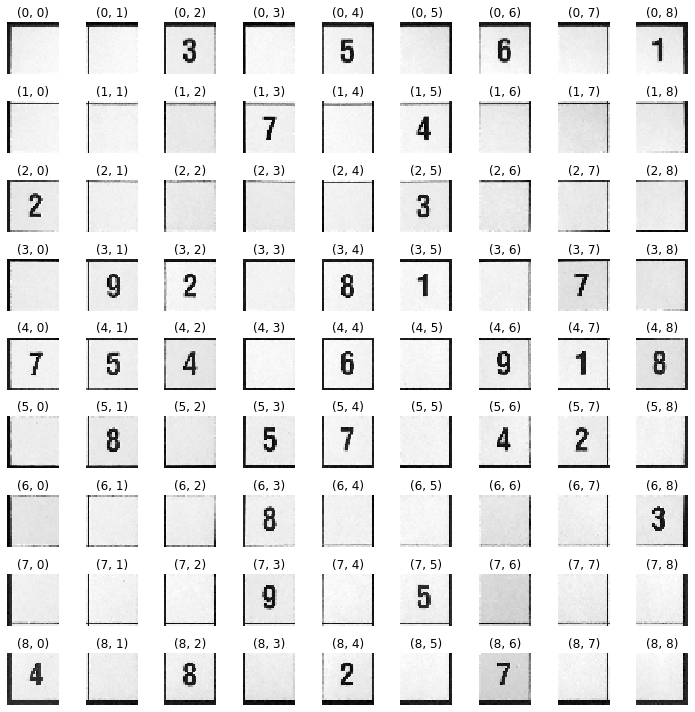

In [22]:
def tm_prepare_cell(cell, size=32):
  cell = convert_to_grayscale(cell)
  cell = cv.resize(cell, (size, size))
  return cell

prepared_cells = [[[tm_prepare_cell(cell) for cell in row] for row in image] for image in cells]
show_cells(prepared_cells[0], cmap="gray")

#### Build dataset of digits to recognize

Template matching requires templates which are matched against input images.
This dataset of templates will be generated in the following.
To determine whether or not our classification actually works in real test cases, we must define which subset of input images will be used for training.
All other images will be used for testing and validation purposes.

In [26]:
train_indices = [0, 3, 4]
test_indices = [i for i in range(len(input_images)) if not i in train_indices]
train_images, test_images = [prepared_cells[x] for x in train_indices], [prepared_cells[x] for x in test_indices]
train_labels, test_labels = [actual_grids[x] for x in train_indices], [actual_grids[x] for x in test_indices]
print("Using", len(train_indices), "images for training")
print("Using", len(test_indices), "images for testing")

Using 3 images for training
Using 4 images for testing


As we know the ground truth values for each cell, we can do a reverse lookup using `get_coords_of_number` and find the coordinates of all cells within the training set containing a specific number.

In [27]:
def get_coords_of_number(haystack, needle):
  haystack = np.array(haystack)
  mask = haystack == needle
  where = np.where(mask)
  return list(zip(*where))

reference_coords = [get_coords_of_number(train_labels, x) for x in range(10)]

for i in range(10):
  print("Found", len(reference_coords[i]), "coordinates for digit", i, "namely:", reference_coords[i])

Found 99 coordinates for digit 0 namely: [(0, 0, 0), (0, 0, 1), (0, 0, 3), (0, 0, 5), (0, 0, 7), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 4), (0, 1, 6), (0, 1, 7), (0, 1, 8), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 2, 4), (0, 2, 6), (0, 2, 7), (0, 2, 8), (0, 3, 0), (0, 3, 3), (0, 3, 6), (0, 3, 8), (0, 4, 3), (0, 4, 5), (0, 5, 0), (0, 5, 2), (0, 5, 5), (0, 5, 8), (0, 6, 0), (0, 6, 1), (0, 6, 2), (0, 6, 4), (0, 6, 5), (0, 6, 6), (0, 6, 7), (0, 7, 0), (0, 7, 1), (0, 7, 2), (0, 7, 4), (0, 7, 6), (0, 7, 7), (0, 7, 8), (0, 8, 1), (0, 8, 3), (0, 8, 5), (0, 8, 7), (0, 8, 8), (2, 0, 2), (2, 0, 3), (2, 0, 5), (2, 0, 6), (2, 0, 7), (2, 0, 8), (2, 1, 1), (2, 1, 2), (2, 1, 6), (2, 1, 7), (2, 1, 8), (2, 2, 0), (2, 2, 3), (2, 2, 4), (2, 2, 5), (2, 2, 6), (2, 2, 8), (2, 3, 1), (2, 3, 2), (2, 3, 3), (2, 3, 5), (2, 3, 6), (2, 3, 7), (2, 4, 1), (2, 4, 2), (2, 4, 4), (2, 4, 6), (2, 4, 7), (2, 5, 1), (2, 5, 2), (2, 5, 3), (2, 5, 5), (2, 5, 6), (2, 5, 7), (2, 6, 0), (2, 6, 2), (2, 6, 3), (2, 6, 4), (2, 6, 5), (

Going from these coordinates we can select all addressed images.

In [0]:
reference_images = [[train_images[i][j][k] for i, j, k in digit_coords] for digit_coords in reference_coords]

The array `reference_images` contains all source images of cells that will be used for template matching.
The element `reference_images[i][j]` contains the `j`-th image of digit `i`.
Once again digit `0` denotes empty cells.
A random subset of these reference images can be visualized using `show_references`.
This method limits the number of displayed images as there can be a large number of references for each digit.
Above each image a title formatted `(i, j)` will be shown, where `i` denotes the digit displayed and `j` is the index of the specific sample.

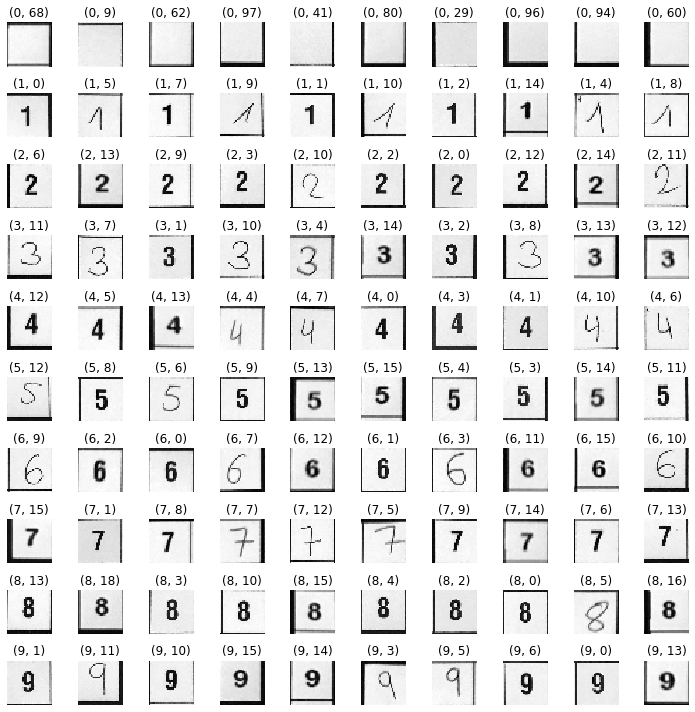

In [29]:
import random

def show_references(images, max_length=10):
  rows = len(images)
  cols = max_length
  plt.figure(figsize=(10, 10))
  for row in range(10):
    i_images_to_show = np.random.permutation(len(images[row]))[:max_length]
    for col, i_image in enumerate(i_images_to_show):
      plt.subplot(rows, cols, row * cols + col + 1)
      plt.title(str((row, i_image)))
      plt.axis("off")
      plt.imshow(images[row][i_image], cmap="gray")
  plt.tight_layout()
  plt.show()

show_references(reference_images)

Looking at the reference images one easily notices that not only the actual digit is included but also the cell`s border may be visible.
Because we do not want to match borders, we crop the reference images in each direction.
By doing so we also allow the template matching algorithm to actually move the template over the input images as there are now multiple offsets where both images will fully overlap.
Digits that are not perfectly centered may then be recognized more easily.

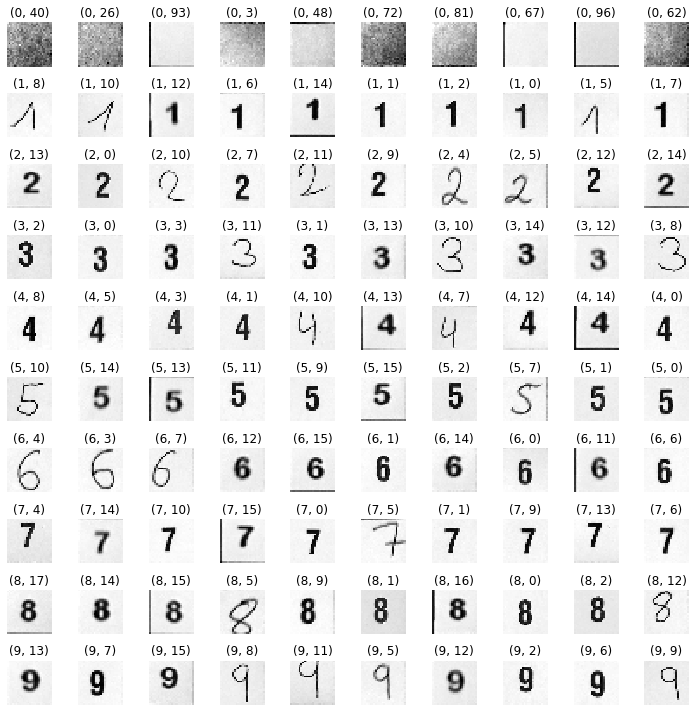

In [30]:
def crop_image(image, padding = 0.1):
  height, width = image.shape[:2]
  p_h, p_w = int(height * padding), int(width * padding)
  return image[p_h:-p_h, p_w:-p_w]

templates = [[crop_image(image) for image in row] for row in reference_images]
show_references(templates)

#### Apply template matching

The template matching itself is done using the method `matchTemplate` provided by OpenCV.
For each cell we repeatedly call this method with each digit and its associated templates.
This results in grayscale maps storing the error at each offset.


In [0]:
def template_match_cell(image, templates, method=cv.TM_SQDIFF_NORMED):
  return [[cv.matchTemplate(image, t, method) for t in T] for T in templates]

matched_cells = [[[template_match_cell(cell, templates) for cell in row] for row in image] for image in prepared_cells]

The array `matched_cells` contains all raw template matching results.
The element `matched_cells[i][j][k][l][m]` contains the grayscale map generated by template matching the cell of the `i`-th image located in the `j`-th row and the `k`-th column with the `m`-th template for digit `l`.

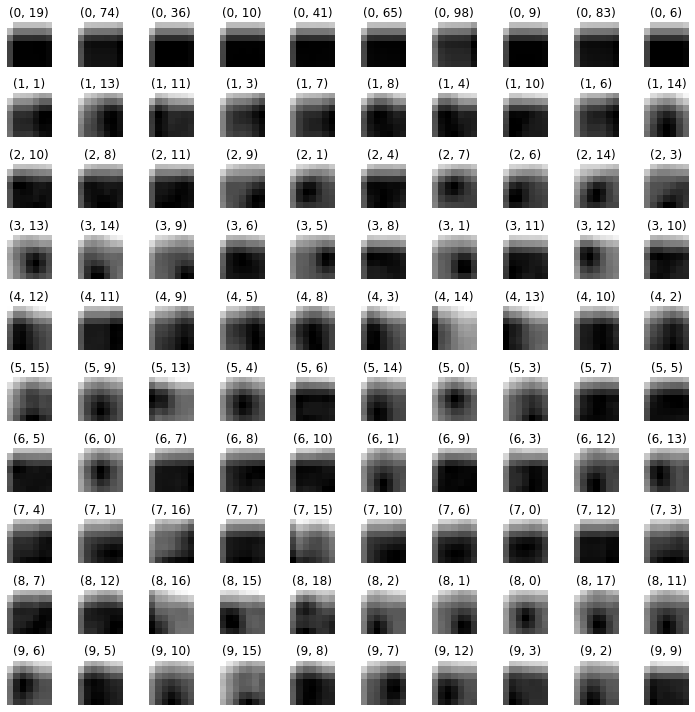

In [32]:
show_references(matched_cells[0][0][2])

#### Vote to determine digit

After having applied the template matching algorithm we have a collection of match results for each input cell.
Based on those results we now need to decide what digit actually is visible.
We propose a number of different methods for this task.

##### Best match wins

This strategy predicts the digit with the lowest minimum error.

In [0]:
def vote_min_error(result):
  best = (-1, math.inf)
  for digit, digit_result in enumerate(result):
    for template_result in digit_result:
      min_error = np.min(template_result)
      if min_error < best[1]:
        best = (digit, min_error)
  return best[0]

min_error_predictions = [[[vote_min_error(result) for result in row] for row in image] for image in matched_cells]

##### Best mean match wins

This strategy predicts the digit whose templates match the best on average.

In [0]:
def vote_mean_error(result):
  best = (-1, math.inf)
  for digit, digit_result in enumerate(result):
    min_errors = [np.min(template_result) for template_result in digit_result]
    mean_error = np.mean(min_errors)
    if mean_error < best[1]:
      best = (digit, mean_error)
  return best[0]

mean_error_predictions = [[[vote_mean_error(result) for result in row] for row in image] for image in matched_cells]

##### Linear classifiers

The following strategies employ linear classifiers from the `sklearn` package that are fitted to the training data.
To train those classifiers our data structures first have to be transformed. 

In [83]:
def result_to_features(result):
  features = []
  for row in result:
    for match in row:
      features.append(np.min(match))
  return np.array(features)

X = []
Y = []
for i_image in train_indices:
  for i_row, row_matches in enumerate(matched_cells[i_image]):
    for i_cell, cell_matches in enumerate(row_matches):
      x = result_to_features(cell_matches)
      X.append(x)
      y = actual_grids[i_image][i_row][i_cell]
      Y.append(y)

X = np.array(X)
Y = np.array(Y)

print("Extracted", X.shape[0], "samples each containing", X.shape[1], "features")

Extracted 243 samples each containing 243 features


The variable `X` contains the training data inputs and `Y` respectively the training data outputs.

In [131]:
class_counts = np.bincount(Y)
print("Occurences of classes:", class_counts)
max_class_count = np.max(class_counts)
print("Maximum occurrences:", max_class_count)

Occurences of classes: [99 15 15 15 15 16 16 17 19 16]
Maximum occurrences: 99


In [0]:
from sklearn.utils import resample

X_unbiased = []
Y_unbiased = []
for i in range(len(class_counts)):
  mask = Y == i
  samples = list(zip(X[mask], Y[mask]))
  resampled = resample(samples, n_samples=max_class_count)
  x_unbiased, y_unbiased = zip(*resampled)
  X_unbiased.extend(x_unbiased)
  Y_unbiased.extend(y_unbiased)

X_unbiased = np.array(X_unbiased)
Y_unbiased = np.array(Y_unbiased)

In [134]:
unbiased_class_counts = np.bincount(Y_unbiased)
print("Occurences of classes:", unbiased_class_counts)

Occurences of classes: [99 99 99 99 99 99 99 99 99 99]


In [0]:
def vote_classifier(classifier, result):
  return classifier.predict([result_to_features(result)])[0]

In [136]:
from sklearn.svm import SVC
svm_classifier = SVC()
svm_classifier.fit(X_unbiased, Y_unbiased)

svm_predictions = [[[vote_classifier(svm_classifier, result) for result in row] for row in image] for image in matched_cells]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [0]:
from sklearn.ensemble import AdaBoostClassifier
boost_classifier = AdaBoostClassifier(n_estimators=100)
boost_classifier.fit(X_unbiased, Y_unbiased)

boost_predictions = [[[vote_classifier(boost_classifier, result) for result in row] for row in image] for image in matched_cells]

#### Evaluation of predictions

Ground truth


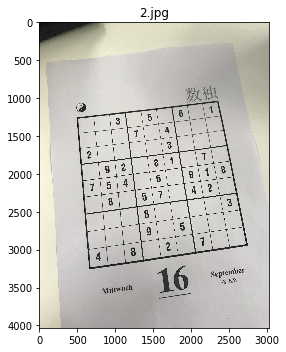

-------------------------------------
|   |   | 3 |   | 5 |   | 6 |   | 1 |
-------------------------------------
|   |   |   | 7 |   | 4 |   |   |   |
-------------------------------------
| 2 |   |   |   |   | 3 |   |   |   |
-------------------------------------
|   | 9 | 2 |   | 8 | 1 |   | 7 |   |
-------------------------------------
| 7 | 5 | 4 |   | 6 |   | 9 | 1 | 8 |
-------------------------------------
|   | 8 |   | 5 | 7 |   | 4 | 2 |   |
-------------------------------------
|   |   |   | 8 |   |   |   |   | 3 |
-------------------------------------
|   |   |   | 9 |   | 5 |   |   |   |
-------------------------------------
| 4 |   | 8 |   | 2 |   | 7 |   |   |
-------------------------------------

Min-Error
-------------------------------------
|   |   | 3 |   | 5 |   | 6 |   | 1 |
-------------------------------------
|   |   |   | 7 |   | 4 |   |   |   |
-------------------------------------
| 2 |   |   |   |   | 3 |   |   |   |
-------------------------------------
|

In [142]:
index = test_indices[0]

print("Ground truth")
show_images([input_images["data"][index]], [input_images["filename"][index]])
print_grid(actual_grids[index])

predictions = {
    "Min-Error": min_error_predictions,
    "Mean-Error": mean_error_predictions,
    "SVM": svm_predictions,
    "AdaBoost": boost_predictions
}

for name, pred in predictions.items():
  print()
  print(name)
  print_grid(pred[index])

In [143]:
from sklearn.metrics import classification_report
y_true = np.array(actual_grids)[test_indices].flatten()

for name, pred in predictions.items():
  print("Classification report for", name)
  y_pred = np.array(pred)[test_indices].flatten()
  print(classification_report(y_true, y_pred))

Classification report for Min-Error
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       198
           1       0.69      0.75      0.72        12
           2       1.00      0.75      0.86        12
           3       0.82      0.75      0.78        12
           4       1.00      0.83      0.91        12
           5       1.00      0.79      0.88        14
           6       0.56      0.64      0.60        14
           7       0.81      0.81      0.81        16
           8       0.79      0.75      0.77        20
           9       0.52      0.79      0.63        14

    accuracy                           0.91       324
   macro avg       0.82      0.79      0.80       324
weighted avg       0.92      0.91      0.91       324

Classification report for Mean-Error
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       198
           1       0.83      0.83      0.83        12
     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Recognize digits using neural networks

In [0]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [0]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [0]:
import random
index = random.choice(range(len(x_train)))
plt.figure()
plt.title(str(y_train[index]))
plt.imshow(x_train[index], cmap="gray")
plt.show()

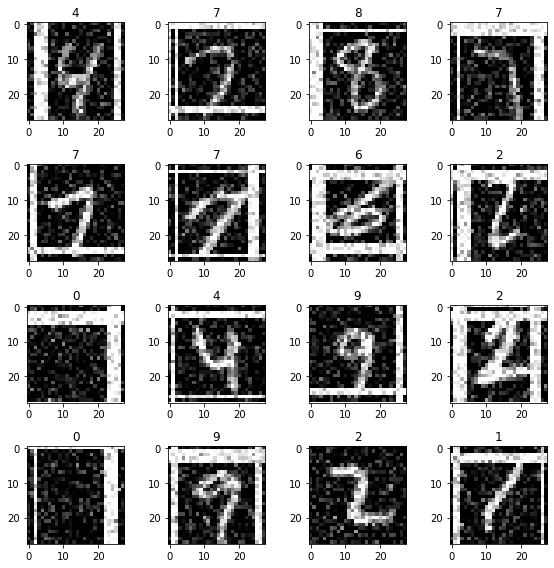

In [457]:
from keras.utils import Sequence

class SudokuDigitGenerator(Sequence):
  def __init__(self, handwritten_samples, 
               border_width=(1, 4), border_offset=(-2, 2), 
               noise=0.2, 
               dilation_prob=0.25,
               dilation_kernel=(1, 2),
               erosion_prob=0.25, 
               erosion_kernel=(1, 2), 
               batch_size=128):
    self.batch_size = batch_size
    self.handwritten_samples = handwritten_samples
    self.n_handwritten_samples = len(self.handwritten_samples[0])
    self.border_width = border_width
    self.border_offset = border_offset
    self.noise = noise
    self.erosion_strength = erosion_strength
    self.erosion_kernel = erosion_kernel

  def __len__(self):
    return 1
  
  def __getitem__(self, index):
    # choose random digits
    indices = np.random.permutation(self.n_handwritten_samples)[:self.batch_size]
    images = self.handwritten_samples[0][indices]
    labels = self.handwritten_samples[1][indices]
    
    # replace 0 digits with whitespace
    for i in range(self.batch_size):
      if labels[i] > 0:
        continue
      images[i] = np.zeros_like(images[i])

    # erode
    for i in range(self.batch_size):
      kernel = random.randint(*self.erosion_kernel), random.randint(*self.erosion_kernel)
      kernel = np.ones(kernel)
      eroded = cv.erode(images[i], kernel)
      s = random.random() * (self.erosion_strength[1] - self.erosion_strength[0]) + self.erosion_strength[0] 
      images[i] = (1 - s) * images[i] + s * eroded

    # random transformation
    for i in range(self.batch_size):
      m = np.eye(3, 3) + np.random.randn(3, 3) * 0.001
      images[i] = cv.warpPerspective(images[i], m, images[i].shape, )

    # draw border
    for i in range(self.batch_size):
      for j in range(4):
        w = random.randint(*self.border_width)
        o = random.randint(*self.border_offset)
        if j == 0:
          images[i][o:o+w, :] = 1
        if j == 1:
          images[i][:, o:o+w] = 1
        if j == 2:
          images[i][-o-w:-o, :] = 1
        if j == 3:
          images[i][:, -o-w:-o] = 1
    
    # add noise
    images += np.random.randn(*images.shape) * self.noise

    # clip
    images[images < 0] = 0
    images[images > 1] = 1

    return images, labels

generator = SudokuDigitGenerator((x_train, y_train), batch_size=16)
batch = generator[0]
show_images(batch[0], batch[1], scaling=(2, 2), cmap="gray")

In [458]:
from keras import models, layers

model = model_input = layers.Input(shape=x_train.shape[1:])
model = layers.Flatten()(model)
model = layers.Dense(128, activation="relu")(model)
model = layers.Dense(10, activation="softmax")(model)
model = models.Model(model_input, model)
model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 28, 28)            0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_22 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [459]:
train_generator = SudokuDigitGenerator((x_train, y_train), batch_size=1024)
test_generator = SudokuDigitGenerator((x_test, y_test), noise=0, batch_size=len(x_test))

validation_x = []
validation_y = []
for i_image in range(len(input_images)):
  for i_row in range(9):
    for i_col in range(9):
      validation_x.append(prepared_cells[i_image][i_row][i_col])
      validation_y.append(actual_grids[i_image][i_row][i_col])
validation_x = np.array(validation_x)
validation_y = np.array(validation_y)

fit_history = model.fit_generator(train_generator, validation_data=(validation_x, validation_y), steps_per_epoch=100, epochs=10)

Epoch 1/10
100/100 [==============================] - 21s 210ms/step - loss: 0.8398 - acc: 0.7566 - val_loss: 1.7319 - val_acc: 0.5714
Epoch 2/10
100/100 [==============================] - 20s 199ms/step - loss: 0.4324 - acc: 0.8753 - val_loss: 2.6843 - val_acc: 0.5591
Epoch 3/10
100/100 [==============================] - 20s 202ms/step - loss: 0.3844 - acc: 0.8880 - val_loss: 3.6676 - val_acc: 0.5556
Epoch 4/10
 67/100 [===================>..........] - ETA: 6s - loss: 0.3604 - acc: 0.8946

KeyboardInterrupt: ignored

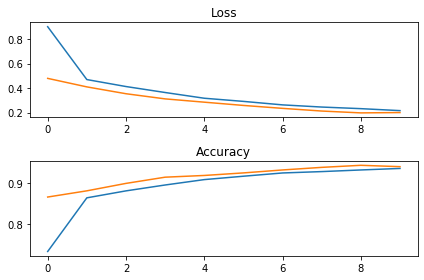

In [413]:
plt.figure()
plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(fit_history.history["loss"])
plt.plot(fit_history.history["val_loss"])
plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(fit_history.history["acc"])
plt.plot(fit_history.history["val_acc"])
plt.tight_layout()
plt.show()

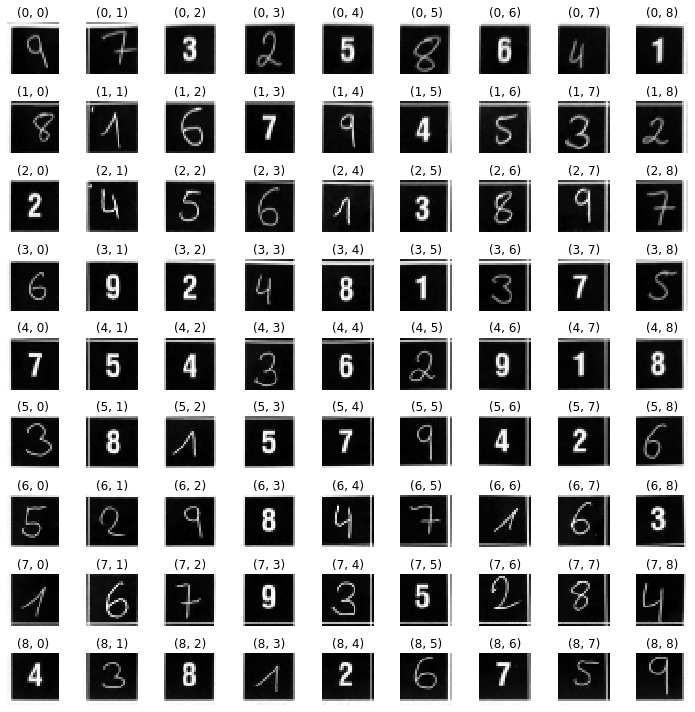

In [414]:
def prepare_cell_nn(cell, padding=0.0):
  p = int(len(cell) * padding)
  cell = cell[p:-p-1, p:-p-1]
  cell = cv.resize(cell, (28, 28), interpolation=cv.INTER_AREA)
  cell = 255 - convert_to_grayscale(cell)
  cell = cell.astype("float32") / 255
  return cell

prepared_cells = [[[prepare_cell_nn(cell) for cell in row] for row in image] for image in cells]
show_cells(prepared_cells[3], cmap="gray")

In [0]:
def detect_digit_nn(cell, model):
  prediction = model.predict(np.expand_dims(cell, 0))[0]
  prediction = np.argmax(prediction)
  return prediction

In [438]:
def detect_grid_nn(cells, model):
  return [[detect_digit_nn(cell, model) for cell in row] for row in cells]

predicted_grids = [detect_grid_nn(x, model) for x in prepared_cells]

print("Actual:")
print_grid(actual_grids[3])

print("Predicted:")
print_grid(predicted_grids[3])

Actual:
-------------------------------------
| 9 | 7 | 3 | 2 | 5 | 8 | 6 | 4 | 1 |
-------------------------------------
| 8 | 1 | 6 | 7 | 9 | 4 | 5 | 3 | 2 |
-------------------------------------
| 2 | 4 | 5 | 6 | 1 | 3 | 8 | 9 | 7 |
-------------------------------------
| 6 | 9 | 2 | 4 | 8 | 1 | 3 | 7 | 5 |
-------------------------------------
| 7 | 5 | 4 | 3 | 6 | 2 | 9 | 1 | 8 |
-------------------------------------
| 3 | 8 | 1 | 5 | 7 | 9 | 4 | 2 | 6 |
-------------------------------------
| 5 | 2 | 9 | 8 | 4 | 7 | 1 | 6 | 3 |
-------------------------------------
| 1 | 6 | 7 | 9 | 3 | 5 | 2 | 8 | 4 |
-------------------------------------
| 4 | 3 | 8 | 1 | 2 | 6 | 7 | 5 | 9 |
-------------------------------------
Predicted:
-------------------------------------
| 9 |   | 1 | 2 | 6 |   | 6 |   |   |
-------------------------------------
| 3 | 5 |   | 1 |   |   |   | 2 |   |
-------------------------------------
| 9 |   |   |   |   | 5 | 5 | 3 |   |
-------------------------------

In [421]:
_n = len(input_images)
_acc_sum = 0
for _i in range(_n):
  _acc = measure_accuracy(actual_grids[_i], predicted_grids[_i])
  _acc_sum += _acc
  print("Grid", _i, "accuracy:", _acc)
print("Average accuracy:", _acc_sum / _n)

Grid 0 accuracy: 0.09876543209876543
Grid 1 accuracy: 0.06172839506172839
Grid 2 accuracy: 0.04938271604938271
Grid 3 accuracy: 0.09876543209876543
Grid 4 accuracy: 0.06172839506172839
Grid 5 accuracy: 0.04938271604938271
Grid 6 accuracy: 0.06172839506172839
Average accuracy: 0.06878306878306878


# Do not look below this line, please!

**Assumption:** The Sudoku grid always has a black border.

**Idea:** Only preserve black (or mostly black) regions within each input image.

But what does it mean for something to be "black"?
In general we can say that something is "black" if it is "dark", i. e. has a low brightness value, and it is "greyish", i. e. has a low saturation value.


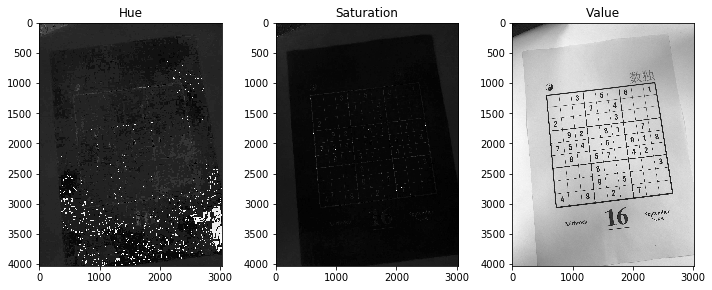

In [0]:
import cv2 as cv
import random

def show_hsv_channels(image):
  image = cv.cvtColor(image, cv.COLOR_RGB2HSV)
  h, s, v = image[:,:,0], image[:,:,1], image[:,:,2]
  plt.figure(figsize=(10, 10))
  plt.subplot(1, 3, 1)
  plt.title("Hue")
  plt.imshow(h, cmap="gray")
  plt.subplot(1, 3, 2)
  plt.title("Saturation")
  plt.imshow(s, cmap="gray")
  plt.subplot(1, 3, 3)
  plt.title("Value")
  plt.imshow(v, cmap="gray")
  plt.tight_layout()
  plt.show()

random_input_image = random.choice(input_images["data"])
show_hsv_channels(random_input_image)